## Dependências

In [77]:
import os
import evaluate
import torch
import networkx as nx
import matplotlib.pyplot as plt
from dotenv import load_dotenv
from datasets import load_dataset, DatasetDict
from transformers import GraphormerForGraphClassification, TrainingArguments, Trainer
from transformers.models.graphormer.collating_graphormer import preprocess_item, GraphormerDataCollator

## Variáveis

In [78]:
load_dotenv()

token = os.getenv("TOKEN")

## Dataset

In [79]:
data_files = {
    "train": "../datasets/train.jsonl",        
    "test": "../datasets/test.jsonl",
    "validation": "../datasets/validation.jsonl",
}
dataset = load_dataset("json", data_files=data_files)
dataset = dataset.shuffle(seed=0)

## Métricas

In [80]:
metric = evaluate.load("accuracy")

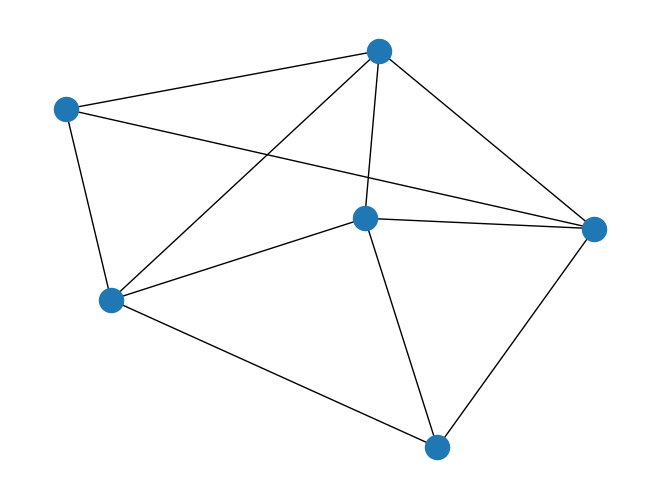

In [81]:
graph = dataset["train"][0]
edges = graph["edge_index"]
num_edges = len(edges[0])
num_nodes = graph["num_nodes"]

G = nx.Graph()
G.add_nodes_from(range(num_nodes))
G.add_edges_from([(edges[0][i], edges[1][i]) for i in range(num_edges)])

nx.draw(G)

In [82]:
print("current_node:", graph["current_node"])
print("target_node:",  graph["target_node"])
print("proximo_salto (y):", graph["labels"])

current_node: 5
target_node: 4
proximo_salto (y): [0]


## Processamento de Dados

In [83]:
dataset_processed = dataset.map(preprocess_item, batched=False)
train_ds = dataset_processed['train']
val_ds = dataset_processed['validation']

In [84]:
train_ds[0].keys()

dict_keys(['graph_id', 'pair', 'path_len', 'num_nodes', 'edge_index', 'edge_attr', 'current_node', 'target_node', 'candidate_node', 'labels', 'input_nodes', 'attn_bias', 'attn_edge_type', 'spatial_pos', 'in_degree', 'out_degree', 'input_edges'])

## Modelo

In [85]:
model = GraphormerForGraphClassification.from_pretrained(
    "clefourrier/pcqm4mv2_graphormer_base",
    token=token,
    num_edges=1024,
    num_classes=2,
    ignore_mismatched_sizes=True
)

d:\Visual Code\Graphormer\venv\Lib\site-packages\huggingface_hub\file_download.py:945: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of GraphormerForGraphClassification were not initialized from the model checkpoint at clefourrier/pcqm4mv2_graphormer_base and are newly initialized because the shapes did not match:
- encoder.graph_encoder.graph_attn_bias.edge_encoder.weight: found shape torch.Size([1537, 32]) in the checkpoint and torch.Size([1025, 32]) in the model instantiated
- classifier.classifier.weight: found shape torch.Size([1, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Argumentos

In [86]:
training_args = TrainingArguments(
    output_dir="../results",
    logging_dir="graph-classification",
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    auto_find_batch_size=False,
    gradient_accumulation_steps=10,
    dataloader_num_workers=4, 
    num_train_epochs=20,
    evaluation_strategy="epoch",
    logging_strategy="epoch"    
)

## Treino

In [87]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    data_collator=GraphormerDataCollator()
)

In [88]:
train_results = trainer.train()

  5%|▌         | 25/500 [00:35<10:07,  1.28s/it]

                                       
                                                
  5%|▌         | 25/500 [00:35<10:07,  1.28s/it]

{'loss': 0.6045, 'grad_norm': 2.256476640701294, 'learning_rate': 4.75e-05, 'epoch': 1.0}









































                                      

                                         
                                                 


  5%|▌         | 25/500 [00:41<10:07,  1.28s/it]



{'eval_loss': 0.6403229236602783, 'eval_runtime': 5.3586, 'eval_samples_per_second': 40.309, 'eval_steps_per_second': 10.077, 'epoch': 1.0}


 10%|█         | 50/500 [01:15<09:27,  1.26s/it]

                                         
                                                 
 10%|█         | 50/500 [01:16<09:27,  1.26s/it]

{'loss': 0.6034, 'grad_norm': 2.715235948562622, 'learning_rate': 4.5e-05, 'epoch': 1.99}







































                                      

                                         
                                                 


 10%|█         | 50/500 [01:22<09:27,  1.26s/it]



{'eval_loss': 0.6165748238563538, 'eval_runtime': 5.5807, 'eval_samples_per_second': 38.705, 'eval_steps_per_second': 9.676, 'epoch': 1.99}


 15%|█▌        | 75/500 [01:56<09:02,  1.28s/it]

                                         
                                                 
 15%|█▌        | 75/500 [01:57<09:02,  1.28s/it]

{'loss': 0.5956, 'grad_norm': 2.3687968254089355, 'learning_rate': 4.25e-05, 'epoch': 2.99}









































                                      

                                         
                                                 


 15%|█▌        | 75/500 [02:03<09:02,  1.28s/it]



{'eval_loss': 0.6178897023200989, 'eval_runtime': 5.3488, 'eval_samples_per_second': 40.383, 'eval_steps_per_second': 10.096, 'epoch': 2.99}


 20%|██        | 100/500 [02:37<08:50,  1.33s/it]

                                         
                                                 
 20%|██        | 100/500 [02:38<08:50,  1.33s/it]

{'loss': 0.5955, 'grad_norm': 1.0603570938110352, 'learning_rate': 4e-05, 'epoch': 3.98}







































                                      

                                         
                                                 


 20%|██        | 100/500 [02:44<08:50,  1.33s/it]



{'eval_loss': 0.6122310161590576, 'eval_runtime': 5.4171, 'eval_samples_per_second': 39.874, 'eval_steps_per_second': 9.969, 'epoch': 3.98}


 25%|██▌       | 125/500 [03:19<08:28,  1.36s/it]

                                         
                                                 
 25%|██▌       | 125/500 [03:20<08:28,  1.36s/it]

{'loss': 0.5946, 'grad_norm': 1.0447503328323364, 'learning_rate': 3.7500000000000003e-05, 'epoch': 4.98}









































                                      

                                         
                                                 


 25%|██▌       | 125/500 [03:25<08:28,  1.36s/it]



{'eval_loss': 0.6153302788734436, 'eval_runtime': 5.5459, 'eval_samples_per_second': 38.947, 'eval_steps_per_second': 9.737, 'epoch': 4.98}


 30%|███       | 150/500 [03:59<07:19,  1.26s/it]

                                         
                                                 
 30%|███       | 150/500 [04:01<07:19,  1.26s/it]

{'loss': 0.5986, 'grad_norm': 0.7887082099914551, 'learning_rate': 3.5e-05, 'epoch': 5.98}







































                                      

                                         
                                                 


 30%|███       | 150/500 [04:06<07:19,  1.26s/it]



{'eval_loss': 0.6110537052154541, 'eval_runtime': 5.3388, 'eval_samples_per_second': 40.459, 'eval_steps_per_second': 10.115, 'epoch': 5.98}


 35%|███▌      | 175/500 [04:40<06:46,  1.25s/it]

                                         
                                                 
 35%|███▌      | 175/500 [04:41<06:46,  1.25s/it]

{'loss': 0.5926, 'grad_norm': 4.318986892700195, 'learning_rate': 3.2500000000000004e-05, 'epoch': 6.97}



































                                      

                                         
                                                 


 35%|███▌      | 175/500 [04:46<06:46,  1.25s/it]



{'eval_loss': 0.6158838868141174, 'eval_runtime': 5.279, 'eval_samples_per_second': 40.917, 'eval_steps_per_second': 10.229, 'epoch': 6.97}


 40%|████      | 200/500 [05:20<06:18,  1.26s/it]

                                         
                                                 
 40%|████      | 200/500 [05:21<06:18,  1.26s/it]

{'loss': 0.5966, 'grad_norm': 1.0102649927139282, 'learning_rate': 3e-05, 'epoch': 7.97}

































                                      

                                         
                                                 


 40%|████      | 200/500 [05:27<06:18,  1.26s/it]



{'eval_loss': 0.613097608089447, 'eval_runtime': 5.3435, 'eval_samples_per_second': 40.423, 'eval_steps_per_second': 10.106, 'epoch': 7.97}


 45%|████▌     | 225/500 [06:00<05:44,  1.25s/it]

                                         
                                                 
 45%|████▌     | 225/500 [06:02<05:44,  1.25s/it]

{'loss': 0.5964, 'grad_norm': 1.3943963050842285, 'learning_rate': 2.7500000000000004e-05, 'epoch': 8.96}





































                                      

                                         
                                                 


 45%|████▌     | 225/500 [06:07<05:44,  1.25s/it]



{'eval_loss': 0.6154087781906128, 'eval_runtime': 5.2669, 'eval_samples_per_second': 41.011, 'eval_steps_per_second': 10.253, 'epoch': 8.96}


 50%|█████     | 251/500 [06:43<05:56,  1.43s/it]

                                         
                                                 
 50%|█████     | 251/500 [06:43<05:56,  1.43s/it]

{'loss': 0.5711, 'grad_norm': 0.5922240018844604, 'learning_rate': 2.4900000000000002e-05, 'epoch': 10.0}



































                                      

                                         
                                                 


 50%|█████     | 251/500 [06:48<05:56,  1.43s/it]



{'eval_loss': 0.6179706454277039, 'eval_runtime': 5.2701, 'eval_samples_per_second': 40.986, 'eval_steps_per_second': 10.247, 'epoch': 10.0}


 55%|█████▌    | 276/500 [07:22<04:41,  1.26s/it]

                                         
                                                 
 55%|█████▌    | 276/500 [07:23<04:41,  1.26s/it]

{'loss': 0.589, 'grad_norm': 2.815896987915039, 'learning_rate': 2.2400000000000002e-05, 'epoch': 11.0}

































                                      

                                         
                                                 


 55%|█████▌    | 276/500 [07:28<04:41,  1.26s/it]



{'eval_loss': 0.6155771613121033, 'eval_runtime': 5.2339, 'eval_samples_per_second': 41.269, 'eval_steps_per_second': 10.317, 'epoch': 11.0}


 60%|██████    | 301/500 [08:05<04:30,  1.36s/it]

                                         
                                                 
 60%|██████    | 301/500 [08:06<04:30,  1.36s/it]

{'loss': 0.5892, 'grad_norm': 3.6701929569244385, 'learning_rate': 1.9900000000000003e-05, 'epoch': 11.99}







































                                      

                                         
                                                 


 60%|██████    | 301/500 [08:12<04:30,  1.36s/it]



{'eval_loss': 0.6177481412887573, 'eval_runtime': 5.376, 'eval_samples_per_second': 40.179, 'eval_steps_per_second': 10.045, 'epoch': 11.99}


 65%|██████▌   | 326/500 [08:48<03:58,  1.37s/it]

                                         
                                                 
 65%|██████▌   | 326/500 [08:49<03:58,  1.37s/it]

{'loss': 0.5906, 'grad_norm': 3.9769127368927, 'learning_rate': 1.74e-05, 'epoch': 12.99}









































                                      

                                         
                                                 


 65%|██████▌   | 326/500 [08:55<03:58,  1.37s/it]



{'eval_loss': 0.622407853603363, 'eval_runtime': 5.4061, 'eval_samples_per_second': 39.955, 'eval_steps_per_second': 9.989, 'epoch': 12.99}


 70%|███████   | 351/500 [09:31<03:22,  1.36s/it]

                                         
                                                 
 70%|███████   | 351/500 [09:33<03:22,  1.36s/it]

{'loss': 0.5902, 'grad_norm': 2.528815507888794, 'learning_rate': 1.49e-05, 'epoch': 13.98}









































                                      

                                         
                                                 


 70%|███████   | 351/500 [09:38<03:22,  1.36s/it]



{'eval_loss': 0.6234344244003296, 'eval_runtime': 5.4015, 'eval_samples_per_second': 39.989, 'eval_steps_per_second': 9.997, 'epoch': 13.98}


 75%|███████▌  | 376/500 [10:15<02:49,  1.37s/it]

                                         
                                                 
 75%|███████▌  | 376/500 [10:16<02:49,  1.37s/it]

{'loss': 0.5894, 'grad_norm': 4.035427093505859, 'learning_rate': 1.24e-05, 'epoch': 14.98}









































                                      

                                         
                                                 


 75%|███████▌  | 376/500 [10:21<02:49,  1.37s/it]



{'eval_loss': 0.6242845058441162, 'eval_runtime': 5.3735, 'eval_samples_per_second': 40.197, 'eval_steps_per_second': 10.049, 'epoch': 14.98}


 80%|████████  | 401/500 [10:58<02:19,  1.41s/it]

                                         
                                                 
 80%|████████  | 401/500 [11:00<02:19,  1.41s/it]

{'loss': 0.588, 'grad_norm': 2.073028087615967, 'learning_rate': 9.900000000000002e-06, 'epoch': 15.98}







































                                      

                                         
                                                 


 80%|████████  | 401/500 [11:05<02:19,  1.41s/it]



{'eval_loss': 0.6227964758872986, 'eval_runtime': 5.404, 'eval_samples_per_second': 39.971, 'eval_steps_per_second': 9.993, 'epoch': 15.98}


 85%|████████▌ | 426/500 [11:42<01:40,  1.36s/it]

                                         
                                                 
 85%|████████▌ | 426/500 [11:43<01:40,  1.36s/it]

{'loss': 0.5869, 'grad_norm': 1.6544418334960938, 'learning_rate': 7.4e-06, 'epoch': 16.97}









































                                      

                                         
                                                 


 85%|████████▌ | 426/500 [11:49<01:40,  1.36s/it]



{'eval_loss': 0.6301193237304688, 'eval_runtime': 5.4003, 'eval_samples_per_second': 39.998, 'eval_steps_per_second': 9.999, 'epoch': 16.97}


 90%|█████████ | 451/500 [12:24<01:02,  1.29s/it]

                                         
                                                 
 90%|█████████ | 451/500 [12:25<01:02,  1.29s/it]

{'loss': 0.5893, 'grad_norm': 4.0799360275268555, 'learning_rate': 4.9000000000000005e-06, 'epoch': 17.97}





































                                      

                                         
                                                 


 90%|█████████ | 451/500 [12:31<01:02,  1.29s/it]



{'eval_loss': 0.6281028985977173, 'eval_runtime': 5.3798, 'eval_samples_per_second': 40.15, 'eval_steps_per_second': 10.038, 'epoch': 17.97}


 95%|█████████▌| 476/500 [13:03<00:29,  1.21s/it]

                                         
                                                 
 95%|█████████▌| 476/500 [13:05<00:29,  1.21s/it]

{'loss': 0.5867, 'grad_norm': 4.492437362670898, 'learning_rate': 2.4000000000000003e-06, 'epoch': 18.96}







































                                      

                                         
                                                 


 95%|█████████▌| 476/500 [13:10<00:29,  1.21s/it]



{'eval_loss': 0.6288594603538513, 'eval_runtime': 5.4973, 'eval_samples_per_second': 39.292, 'eval_steps_per_second': 9.823, 'epoch': 18.96}


100%|██████████| 500/500 [13:45<00:00,  1.37s/it]

                                         
                                                 
100%|██████████| 500/500 [13:46<00:00,  1.37s/it]d:\Visual Code\Graphormer\venv\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


{'loss': 0.5723, 'grad_norm': 2.898878574371338, 'learning_rate': 0.0, 'epoch': 19.92}









































                                      

                                         
                                                 


100%|██████████| 500/500 [13:51<00:00,  1.37s/it]



                                         
                                                 
100%|██████████| 500/500 [13:51<00:00,  1.66s/it]

{'eval_loss': 0.6292149424552917, 'eval_runtime': 5.3244, 'eval_samples_per_second': 40.568, 'eval_steps_per_second': 10.142, 'epoch': 19.92}
{'train_runtime': 831.9405, 'train_samples_per_second': 24.064, 'train_steps_per_second': 0.601, 'train_loss': 0.5910076599121094, 'epoch': 19.92}


## Save

In [89]:
trainer.save_model(output_dir="../model")
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()

***** train metrics *****
  epoch                    =    19.9203
  total_flos               =        0GF
  train_loss               =      0.591
  train_runtime            = 0:13:51.94
  train_samples_per_second =     24.064
  train_steps_per_second   =      0.601
